In [1]:
import glob
import sys
import warnings
import joblib
import xrft
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from AutoML import AutomatedRegression

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import prediction_ML

# - Load data

In [3]:
data_dir = "/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/"
data_type = "4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc"
scenarios = glob.glob(f"{data_dir}*{data_type}")

In [4]:
#  Dropping Aghulas scenarios for now
# scenarios = [x for x in scenarios if not 'Aghulas' in x]
scenarios_train = [x for x in scenarios if 'Azores' not in x and 'Scotland' not in x]
scenarios_test = [x for x in scenarios if 'Azores'  in x or 'Scotland' in x]
scenarios_train, scenarios_test

(['/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Barbedos_20201110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Carrib_20231104_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Iceland_20231107_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Morroco_20201103_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Aghulas_20191110_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Hawaii_20201106_4ML_phased_array_la3dot2_vxsat8000_PRF4_resspa200.nc',
  '/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/data_processed/Ag

In [15]:
n = 20 # number of azimuth cells to consider from center (e.g. total azimuth cells is 2*n +1)
spacing_slow_time = 2*n # pixels
spacing_ground_range = 2*n # pixels
N_avg_grg = data.grg_N # data is averaged over N pixels along ground range
N_avg_st = data.slow_time_N # data is averaged over N pixels along slow_time

# --------------Training--------------
X_train = []
y_train = []
for scenario in scenarios_train:
    data = xr.open_dataset(scenario)

    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
    except:
        pass

    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    # Training
    X_train_spaced = X_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1, 2*n+1)
    y_train_spaced = y_data.isel(placeholder=slice(None,None, spacing_slow_time), grg=slice(None,None, spacing_ground_range)).values.reshape(-1)

    data_train = pd.DataFrame(np.column_stack((X_train_spaced,y_train_spaced))).dropna()
    X_train.append(data_train.iloc[:,:-1])
    y_train.append(data_train.iloc[:,-1])

X_train = pd.concat(X_train)
y_train = pd.concat(y_train)


# --------------Testing--------------
X_test = []
y_test = []
for scenario in scenarios_test:
    data = xr.open_dataset(scenario)
    
    # slow time can not be indexed for concatonation step, remove indexing if present
    try:
        data = data.reset_index('slow_time')
    except:
        pass
    
    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    X_test_pre = X_data.values.reshape(-1, 2*n+1)
    y_test_pre = y_data.values.reshape(-1)

    data_test = pd.DataFrame(np.column_stack((X_test_pre,y_test_pre))).dropna()
    X_test.append(data_test.iloc[:,:-1])
    y_test.append(data_test.iloc[:,-1])
                  

In [16]:
def warning_catcher(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return 

def warning_catcher2(function, *args):
    with warnings.catch_warnings(record=True) as caught_warnings:
        output_buffer = io.StringIO()
        stdout_save = sys.stdout
        sys.stdout = output_buffer

        try:
            result = function(*args)
        except Exception as e:
            sys.stdout = stdout_save
            print(e)
        
        sys.stdout = stdout_save

    return result

In [19]:
# Instantiate model and overwrite automated Train / Test split
from sklearn.metrics import median_absolute_error, r2_score

ML = AutomatedRegression(
    X=X_train,           # NOTE these are overwritten 
    y=X_train,           # NOTE these are overwritten 
    timeout=1200, # seconds
    n_trial=100,
    metric_optimise = median_absolute_error, # r2_score
    optimisation_direction='minimize',
    models_to_optimize=['bayesianridge', 'lassolars'],#, 'catboost', 'lightgbm', 'xgboost'],
    models_to_assess=['bayesianridge','lassolars'],# 'catboost', 'lightgbm', 'xgboost'],
    n_jobs=6,
    # n_weak_models=4,
    reload_study=False,
    reload_trial_cap=True,
    write_folder='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_2by2km_w_noise_n_20_11Tr_2Te_v1/',
)

ML.X_test = X_test[0]
ML.X_train = X_train
ML.y_test = y_test[0]
ML.y_train = y_train 


warning_catcher(ML.apply)
# ML.apply()
ML.summary

/Users/opodriscoll/Documents/Scripts/DopSCA/src/automl/AutoML/automl.py:236: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_columns = (~self.X.applymap(np.isreal).any(axis = 0))
[I 2024-02-01 16:57:07,094] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2024-02-01 16:57:07,217] Using an existing study with name 'regression_lassolars' instead of creating a new one.
[I 2024-02-01 16:57:07,259] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2024-02-01 16:57:07,315] Using an existing study with name 'regression_lassolars' instead of creating a new one.


{'bayesianridge_best': [[0.43360463, 0.0010302865],
  [-0.006881808870791017, 0.0005008068397329249]],
 'lassolars_best': [[0.42933577, 0.0011037458],
  [0.009339416061503103, 0.0006246567628813293]],
 'stacked': [[0.4311530442268439, 0.000848309875302949],
  [0.0022433177096568002, 0.0005880479568335307]]}

In [20]:
model = joblib.load('/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_2by2km_w_noise_n_20_11Tr_2Te_v1/stacked_model.joblib')

In [21]:
# plot estimation performance per test scenario 

for i, scenario in enumerate(scenarios_test):
    data = xr.open_dataset(scenario)
    plt.figure()
    data.nrcs_scat_w_noise.T.plot(robust =True, vmin =0, cmap = 'Greys_r')
    # scenario_inverse = scenario.replace('4ML_', '4ML_inverse_')
    # data_inverse = xr.open_dataset(scenario_inverse)

    try:
        data = data.reset_index('slow_time')
        # data_inverse = data_inverse.reset_index('slow_time')
    except:
        pass
    
    x_data_avg = data.nrcs_scat_w_noise.rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()
    y_data_avg = (data.V_leakage_pulse_rg - data.V_leakage_pulse_rg_inverted).rolling(grg=N_avg_grg, slow_time=N_avg_st, center=True).mean()

    X_data = xr.concat([x_data_avg.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time') for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')
    y_data = xr.concat([y_data_avg.isel(slow_time=i) for i in range(n, data.sizes['slow_time']-n)], dim='placeholder')

    # X_data = xr.concat([data.nrcs_scat_w_noise.isel(slow_time=slice(i-n, 1+i+n)).drop_vars('slow_time')  for i in range(n, len(data.nrcs_scat_w_noise['slow_time'])-n)], dim='placeholder')
    # y = data.V_leakage_pulse_rg_subscene - data.V_leakage_pulse_rg_subscene_inverted
    # y_data = xr.concat([y.isel(slow_time=i) for i in range(n, len(y['slow_time'])-n)], dim='placeholder')


    y_pred = warning_catcher2(model.predict, X_test[i])
    y_shape = y_data.shape

    theoretical_length = y_data.values.reshape(-1).shape
    A = np.nan * np.arange(theoretical_length[0])
    A[y_test[i].index.values] = y_test[i].values
    A = A.reshape(y_shape)

    B = np.nan * np.arange(theoretical_length[0])
    B[y_test[i].index.values] = y_pred
    B = B.reshape(y_shape)

    ds = xr.Dataset(
        data_vars=dict(
            difference = ([ "slow_time", "grg"], A-B),
            original = ([ "slow_time", "grg"], A),
            new = ([ "slow_time", "grg"], B),
    ),
        coords=dict(
            slow_time=(["slow_time"], y_data.slow_time.values),
            grg=(["grg"], y_data.grg.values),
        ),
    )

    # ds = ds.rolling(grg=data.attrs['grg_N'], slow_time=data.attrs['slow_time_N'], center=True).mean()

    perf_ML = np.sqrt(np.nanmean(ds.difference**2)), np.nanmedian(ds.difference)
    perf_inv = np.sqrt(np.nanmean(ds.original**2)), np.nanmedian(ds.original)

    print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
    print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")



    # ------------- plotting --------------# 
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

    vmin = -2;
    vmax = 2
    im0 = axes[0].imshow(ds.original, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im1 = axes[1].imshow(ds.new, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    im2 = axes[2].imshow(ds.difference, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
    [ax.set_xlabel('grg pixel') for ax in axes]
    axes[0].set_ylabel('slow time pixel')
    axes[0].set_title('Validation')
    axes[1].set_title('Estimate')
    axes[2].set_title('Difference')
    cbar = plt.colorbar(im0, ax=axes[2])
    cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
    fig.tight_layout()

ML performance, RMSE: 0.652 m/s, median error: -0.026 m/s
Inversion performance, RMSE: 0.652 m/s, median error: 0.007 m/s
ML performance, RMSE: 0.637 m/s, median error: 0.041 m/s
Inversion performance, RMSE: 0.637 m/s, median error: 0.006 m/s


ML performance, RMSE: 0.666 m/s, median error: -0.102 m/s
Inversion performance, RMSE: 0.653 m/s, median error: 0.003 m/s
ML performance, RMSE: 0.671 m/s, median error: -0.027 m/s
Inversion performance, RMSE: 0.664 m/s, median error: 0.027 m/s


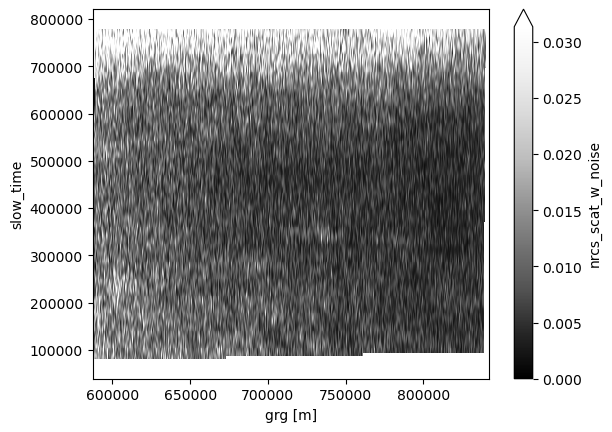

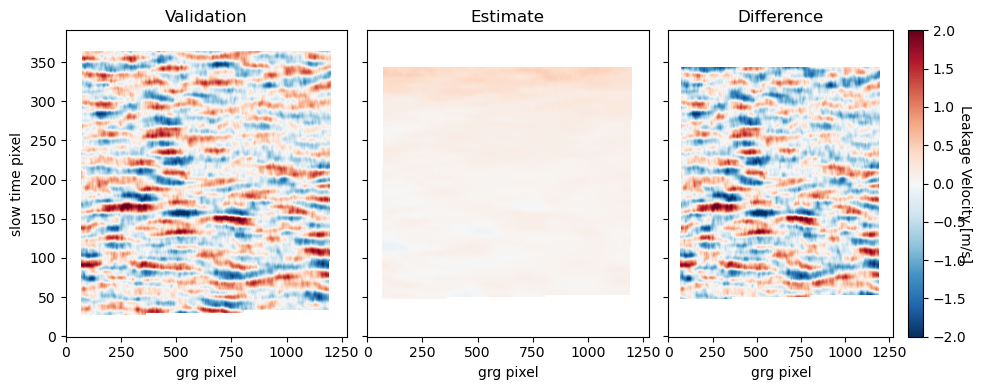

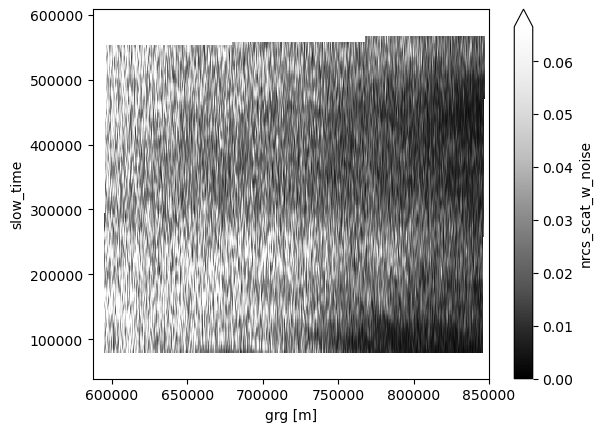

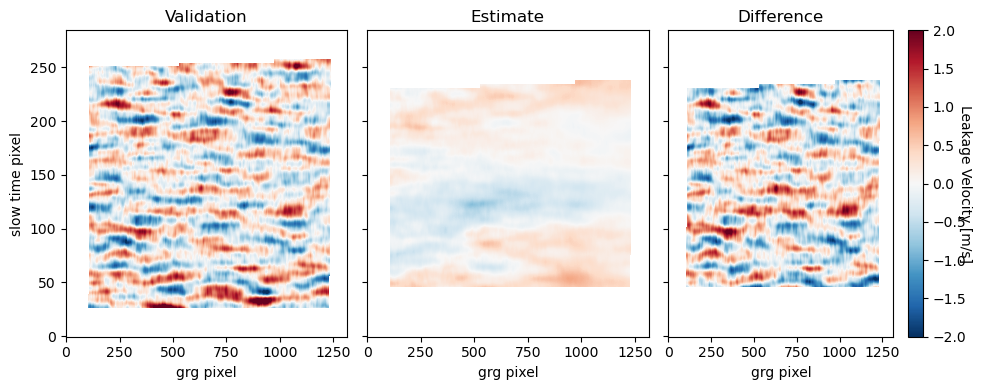

In [11]:
model_ML='/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/ML_analyses/Vleak_subscene_w_noise_n_20_5Tr_2Te_v1/stacked_model.joblib'

for scenario in scenarios_test:
   
   ds = prediction_ML(filename=scenario, model_ML=model_ML)

   plt.figure()
   ds.nrcs_scat_w_noise.T.plot(robust =True, vmin =0, cmap = 'Greys_r')

   ds['original'] = ds['V_leakage_pulse_rg_subscene'] - ds['V_leakage_pulse_rg_subscene_inverted']
   ds['difference'] = ds['original'] - ds['estimate']

   perf_ML = np.sqrt(np.nanmean(ds['difference']**2)), np.nanmedian(ds['difference'])
   perf_inv = np.sqrt(np.nanmean(ds['original']**2)), np.nanmedian(ds['original'])

   print(f"ML performance, RMSE: {perf_ML[0]:.3f} m/s, median error: {perf_ML[1]:.3f} m/s")
   print(f"Inversion performance, RMSE: {perf_inv[0]:.3f} m/s, median error: {perf_inv[1]:.3f} m/s")


   fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)

   vmin = -2;
   vmax = 2
   im0 = axes[0].imshow(ds.original.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   im1 = axes[1].imshow(ds.estimate.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   im2 = axes[2].imshow(ds.difference.T, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, cmap='RdBu_r')
   [ax.set_xlabel('grg pixel') for ax in axes]
   axes[0].set_ylabel('slow time pixel')
   axes[0].set_title('Validation')
   axes[1].set_title('Estimate')
   axes[2].set_title('Difference')
   cbar = plt.colorbar(im0, ax=axes[2])
   cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270)
   fig.tight_layout()

## - Frequency domain analysis

/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


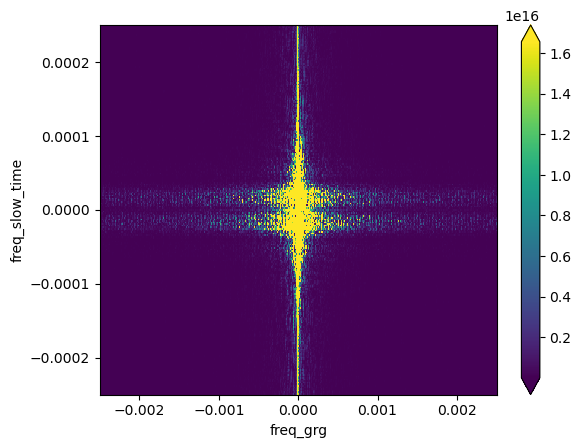

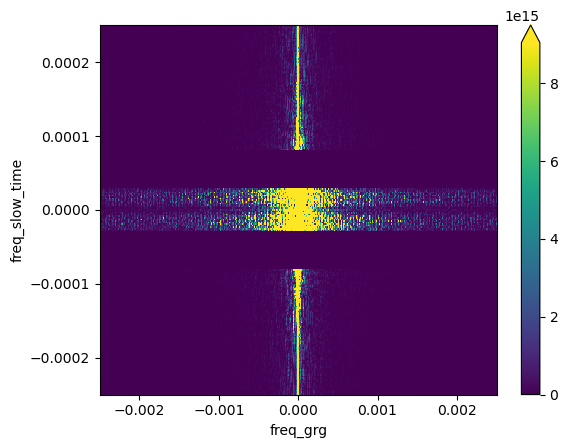

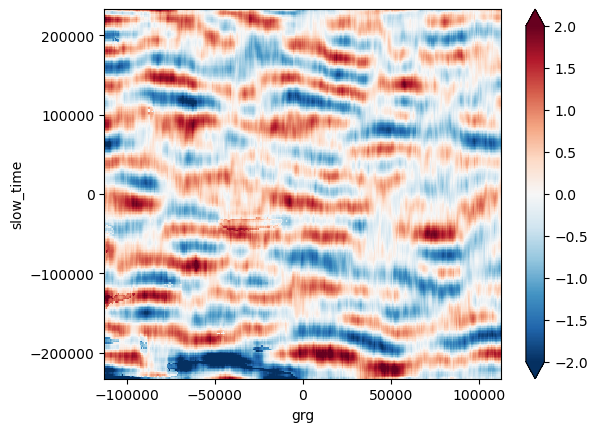

In [9]:
d4fft = ds.difference.dropna(dim ='slow_time', how = 'all').dropna(dim='grg')
d4fft = d4fft.assign_coords(
    {'slow_time':('slow_time',d4fft.slow_time.values - np.mean(d4fft.slow_time.values)),
    'grg':('grg',d4fft.grg.values - np.mean(d4fft.grg.values))}
    )

ps = xrft.fft(d4fft, window = 'boxcar')
ps_l = np.log10(ps)
plt.figure()
(abs(ps)**2).plot(robust = True)

condition = (abs(ps.freq_slow_time) < 8e-5) & (abs(ps.freq_slow_time) > 3e-5)

ps_f = xr.where(condition, 0,  ps)
plt.figure()
(abs(ps_f)**2).plot(robust = True)

inv = np.real(xrft.ifft(ps_f))
plt.figure()
inv.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r')

In [10]:
print(f"RMSE before and after removal of incorrect noise frequencies: {perf_ML[0]:.3f} m/s & {np.sqrt(np.nanmean(inv**2)):.3f} m/s")

RMSE before and after removal of incorrect noise frequencies: 0.810 m/s & 0.755 m/s


## t-SNE presentation

In [12]:
from sklearn.manifold import TSNE

scene = -1 # NOTE only works for the most recent scene as y_pred is the last scenario run
n_indexes = 10000
random_state = 42
X = X_test[scene].sample(n = n_indexes, random_state = random_state)
indexes = X.index.values
colour = (y_test[scene] - y_pred).loc[indexes]

# Create a t-SNE model with 2 components (for 2D visualization)
tsne = TSNE(n_components=2, random_state=random_state, perplexity=15)

# Fit and transform the data
X_tsne = tsne.fit_transform(X)

In [61]:
%matplotlib qt

fig, axes = plt.subplots(figsize=(6, 4))
vmax = np.percentile(abs(colour), 90)
im = axes.scatter(X_tsne[:, 0], X_tsne[:, 1], c = colour, picker=True, cmap ='PRGn',vmax = vmax, vmin = -abs(vmax) )

def to_dB(x):
    return 10*np.log10(x)

def on_pick(event):
    index = event.ind[0]

    plt.figure(figsize = (5.5,3.5))
    plt.plot(to_dB(X.iloc[index].values))
    plt.xlabel('index'); plt.ylabel('nrcs [dB]')
    plt.title(f'index: {index}')

fig.canvas.callbacks.connect('pick_event', on_pick)


cbar = plt.colorbar(im, ax=axes)
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270, labelpad=10)


Text(0, 0.5, 'Leakage Velocity [m/s]')

In [13]:
%matplotlib qt
import mplcursors  # Import mplcursors library

fig, axes = plt.subplots(figsize=(6, 4))
vmax = np.percentile(abs(colour), 90)
im = axes.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colour, cmap='PRGn', vmax=vmax, vmin=-abs(vmax))

def to_dB(x):
    return 10 * np.log10(x)

first_hover_flag = [True] 

def on_hover(sel):
    index = sel.target.index
    if first_hover_flag[0]:
        first_hover_flag[0] = False
        global axes2
        fig2, axes2 = plt.subplots(figsize=(5.5, 3.5))
        
    axes2.clear()
    axes2.plot(to_dB(X.iloc[index].values))
    axes2.set_xlabel('index')
    axes2.set_ylabel('nrcs [dB]')
    axes2.set_title(f'index: {index}')
    plt.draw()

# Use mplcursors to connect the hover event
mplcursors.cursor(hover=True).connect("add", on_hover)

cbar = plt.colorbar(im, ax=axes)
cbar.ax.set_ylabel('Leakage Velocity [m/s]', rotation=270, labelpad=10)

plt.draw()


/Users/opodriscoll/miniconda3/envs/env_AutoML_xarray/lib/python3.9/site-packages/mplcursors/_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [101]:
%matplotlib inline 